## Import the libraries

In [53]:
from transformers import AutoTokenizer
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

# Params

In [32]:
embeddings_dimension = 8 # also known as "hidden_size" in hugginface
num_attention_heads = 2
attention_head_size = 16
num_transformer_blocks = 2
max_context_lenght = 25 # also known as "max_position_embeddings" in hugginface
vocab_size = 0 # Set it to zero because it's going to update it later

In [73]:
def createPlot(nums):
    # Convert embeddings to numpy for visualization
    embeddings_np = nums.detach().numpy()

    # Get dimensions
    embeddings_dimension = embeddings_np.shape[1]
    tokenized_input_length = embeddings_np.shape[0]
    tokenized_input = list(range(tokenized_input_length))

    # Plotting embeddings
    fig, ax = plt.subplots(figsize=(15, 5))  # Increase figure size for bigger squares
    cax = ax.matshow(embeddings_np, aspect='auto', cmap='viridis')

    # Add color bar for reference
    fig.colorbar(cax)

    # Set labels
    ax.set_xticks(np.arange(embeddings_dimension))
    ax.set_yticks(np.arange(tokenized_input_length))
    ax.set_xticklabels([f'Dim {i}' for i in range(embeddings_dimension)])
    ax.set_yticklabels([f'Token {i}' for i in tokenized_input])

    # Rotate the tick labels and set their alignment
    plt.xticks(rotation=90)
    plt.xlabel('Embedding Dimensions')
    plt.ylabel('Tokens')

    # Adding numerical values to the plot
    for i in range(tokenized_input_length):
        for j in range(embeddings_dimension):
            text = ax.text(j, i, f'{embeddings_np[i, j]:.2f}', ha='center', va='center', color='white')

    plt.title('Embeddings Visualization')
    plt.show()

# Tokenisation

In [22]:
input_text = "SThis is a input textE" # Because its a character leverl tokenizer the SOS is: S and the EOS is: E

# Here w create the Tokenizer
chars = sorted(list(set(input_text)))
vocab_size = len(chars)
print(f"vocab size: {vocab_size}")

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
tokenize = lambda s: [stoi[c] for c in s] # tokenizer: take a string, output a list of integers
detokenize = lambda l: ''.join([itos[i] for i in l]) # detokenizer: take a list of integers, output a string

vocab size: 14


In [23]:
tokenized_input = tokenize(input_text)
eos_token = tokenized_input[-1]
sos_token = tokenized_input[0]

print(f"eos_token: {eos_token}")
print(f"sos_token: {sos_token}")
print(f"The tokenized Tensor: {tokenized_input}")
print(f"The context size of the current input text is: {len(tokenized_input)}")
print(f"The detokenized Tensor: \"{detokenize(tokenized_input)}\"")

eos_token: 1
sos_token: 2
The tokenized Tensor: [2, 3, 6, 7, 10, 0, 7, 10, 0, 4, 0, 7, 8, 9, 12, 11, 0, 11, 5, 13, 11, 1]
The context size of the current input text is: 22
The detokenized Tensor: "SThis is a input textE"


# Create Embeddings

In [24]:
embedder = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embeddings_dimension, padding_idx=eos_token)
embeddings = embedder(torch.tensor(tokenized_input))

print(f"The shape is: {embeddings.shape}")
print(embeddings)

The shape is: torch.Size([22, 8])
tensor([[ 1.8916, -0.0138, -0.2121,  2.1157, -0.0718, -1.3093,  0.9794,  0.9966],
        [-0.8076,  0.8293,  0.3373,  1.5442,  1.0325,  1.2292,  0.0623, -2.1094],
        [-0.0957, -0.1622,  0.5268,  1.6064, -0.3110, -1.8880, -0.6368, -0.4750],
        [ 1.5842, -0.4195, -1.1202, -0.5330, -0.7852,  0.4069, -1.0324, -0.4364],
        [-1.2373, -0.4454,  1.6577,  0.5674, -1.7532, -0.1483, -1.9084,  1.2612],
        [ 0.3786,  0.9452, -0.3607,  0.0605,  0.8400,  0.5901,  0.2146, -2.7304],
        [ 1.5842, -0.4195, -1.1202, -0.5330, -0.7852,  0.4069, -1.0324, -0.4364],
        [-1.2373, -0.4454,  1.6577,  0.5674, -1.7532, -0.1483, -1.9084,  1.2612],
        [ 0.3786,  0.9452, -0.3607,  0.0605,  0.8400,  0.5901,  0.2146, -2.7304],
        [ 0.0526,  1.1297, -0.2425, -0.5826,  1.0083, -0.3401, -0.7440, -0.2765],
        [ 0.3786,  0.9452, -0.3607,  0.0605,  0.8400,  0.5901,  0.2146, -2.7304],
        [ 1.5842, -0.4195, -1.1202, -0.5330, -0.7852,  0.4069, -

## Create Plot

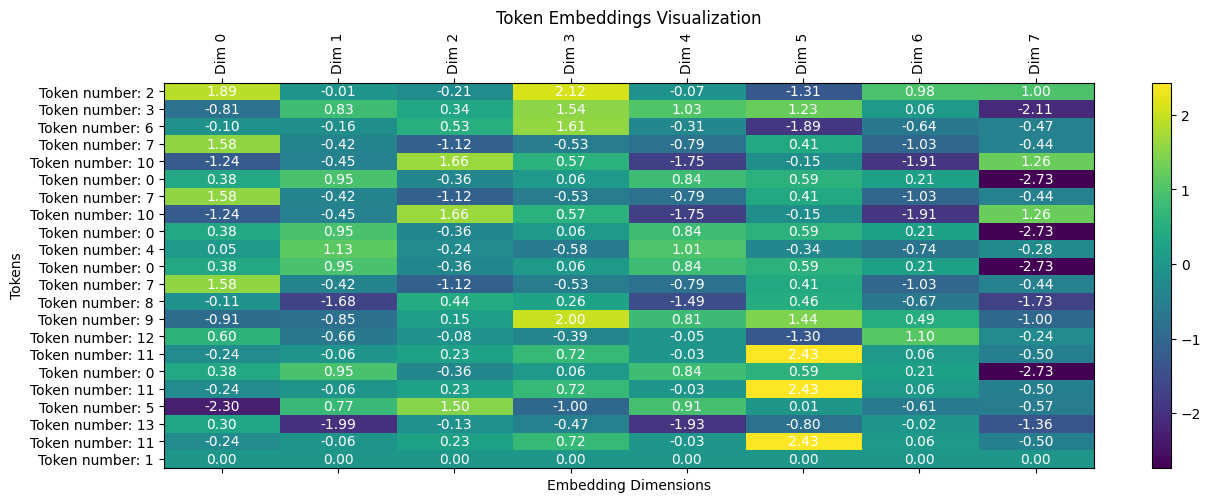

In [66]:
# Convert embeddings to numpy for visualization
createPlot(embeddings)

# LayerNorm

torch.Size([22, 8])


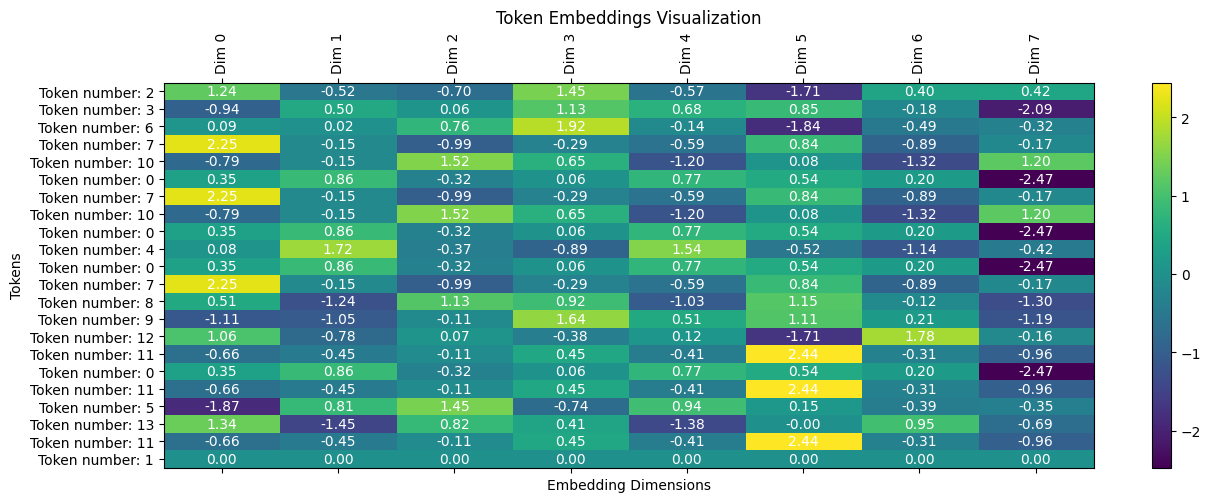

In [72]:
post_attention_layernorm = nn.LayerNorm(embeddings_dimension)
attention_input = post_attention_layernorm(embeddings)

print(attention_input.shape)
createPlot(attention_input)

# Multihead Attention

In [76]:
class AttentionHead(nn.Module):
    """ one head of self-attention """

    def __init__(self):
        super().__init__()
        self.key_proj = nn.Linear(embeddings_dimension, attention_head_size, bias=False)
        self.query_proj = nn.Linear(embeddings_dimension, attention_head_size, bias=False)
        self.value_proj = nn.Linear(embeddings_dimension, attention_head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(max_context_lenght, max_context_lenght)))

        self.dropout = nn.Dropout(0.0)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        L, D = x.shape

        keys = self.key_proj(x)   # (B,T,hs)
        print("keys beggining")
        createPlot(keys)
        queries = self.query_proj(x) # (B,T,hs)
        print("queries beggining")
        createPlot(queries)
        values = self.value_proj(x) # (B,T,hs)
        print("values beggining")
        createPlot(values)
        
        # ATTENTION START
        # compute attention scores ("affinities")
        wei = queries @ keys.transpose(-2,-1) * keys.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        print("keys and queries multiplied")
        createPlot(wei)
        # Mask the input
        wei = wei.masked_fill(self.tril[:L, :L] == 0, float('-inf')) # (B, T, T)
        print("Masked")
        createPlot(wei)

        wei = F.softmax(wei, dim=-1) # (B, T, T)
        print("Softmaxed")
        createPlot(wei)
        wei = self.dropout(wei)
        print("droped out")
        createPlot(wei)
        # perform the weighted aggregation of the values
        out = wei @ values # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        print("Attentino head output")
        createPlot(out)
        # ATTENTION END

        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self):
        super().__init__()
        self.heads = nn.ModuleList([AttentionHead() for _ in range(num_attention_heads)])
        self.out_proj = nn.Linear(attention_head_size * num_attention_heads, embeddings_dimension, bias=False)
        self.dropout = nn.Dropout(0.0)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        createPlot(out)
        out = self.out_proj(out)
        createPlot(out)
        return self.dropout(out)

In [77]:
mha = MultiHeadAttention()
print(mha)

MultiHeadAttention(
  (heads): ModuleList(
    (0-1): 2 x AttentionHead(
      (key_proj): Linear(in_features=8, out_features=16, bias=False)
      (query_proj): Linear(in_features=8, out_features=16, bias=False)
      (value_proj): Linear(in_features=8, out_features=16, bias=False)
      (dropout): Dropout(p=0.0, inplace=False)
    )
  )
  (out_proj): Linear(in_features=32, out_features=8, bias=False)
  (dropout): Dropout(p=0.0, inplace=False)
)


keys beggining


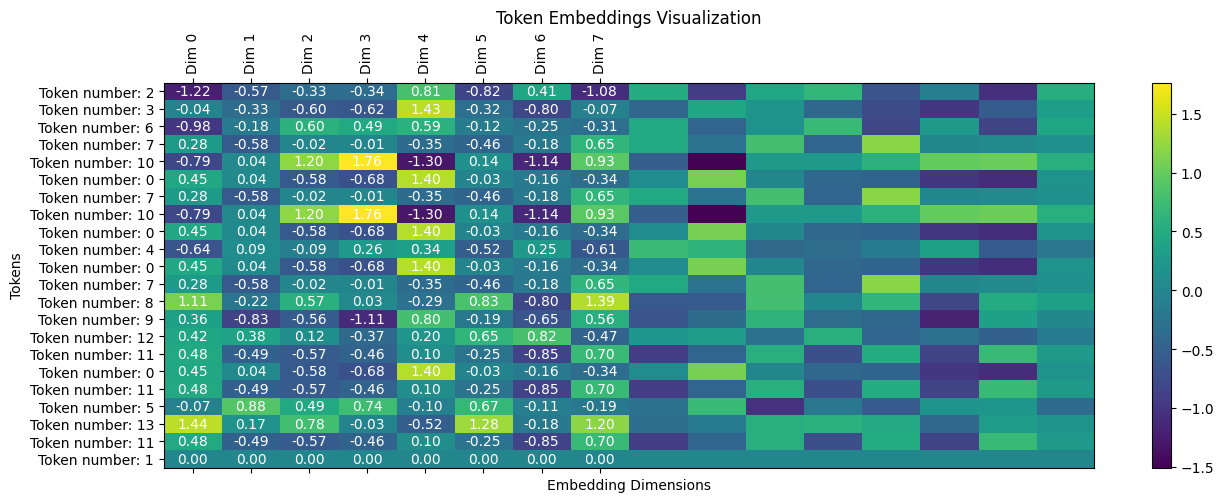

queries beggining


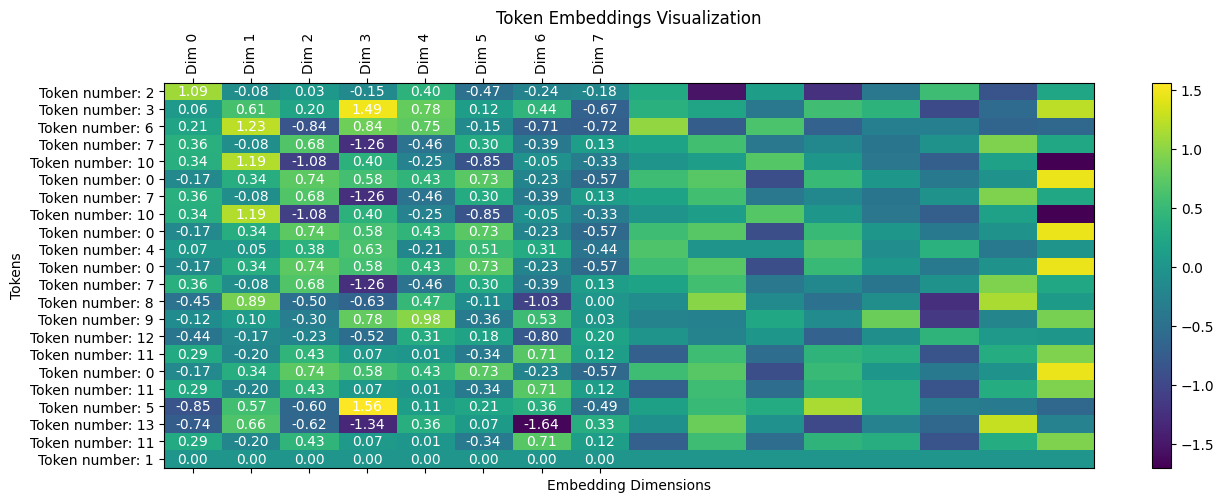

values beggining


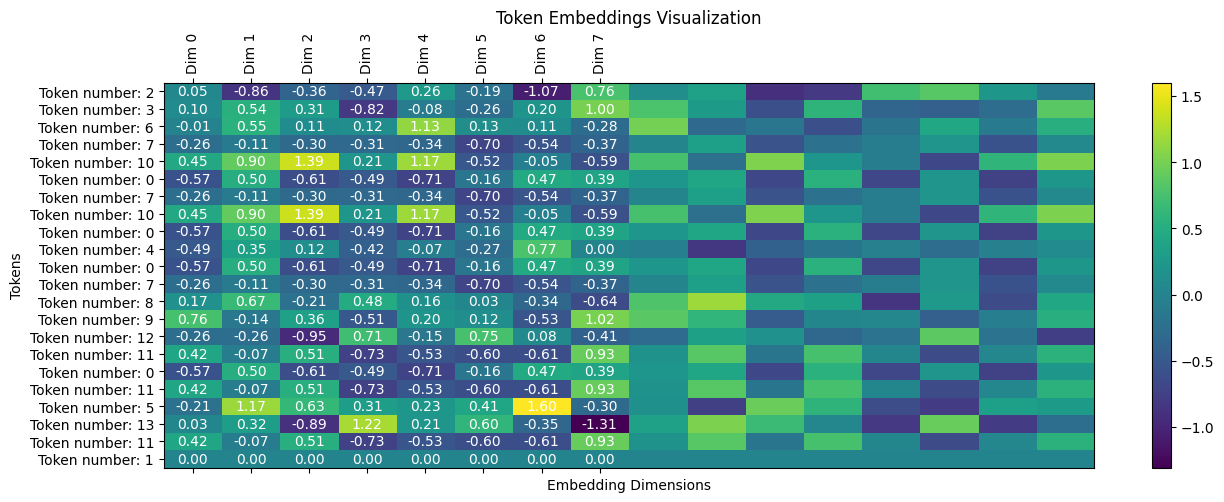

keys and queries multiplied


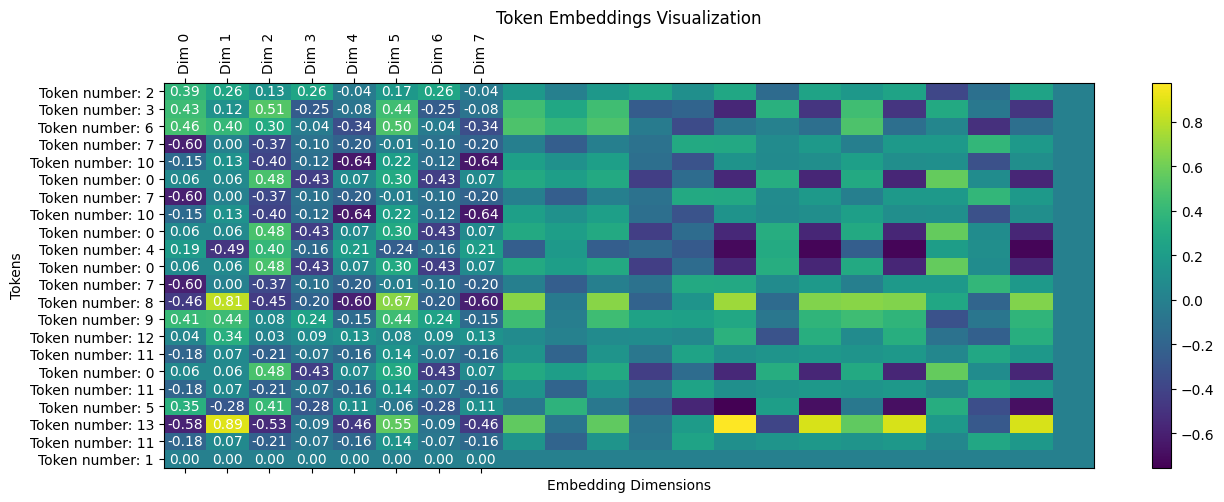

Masked


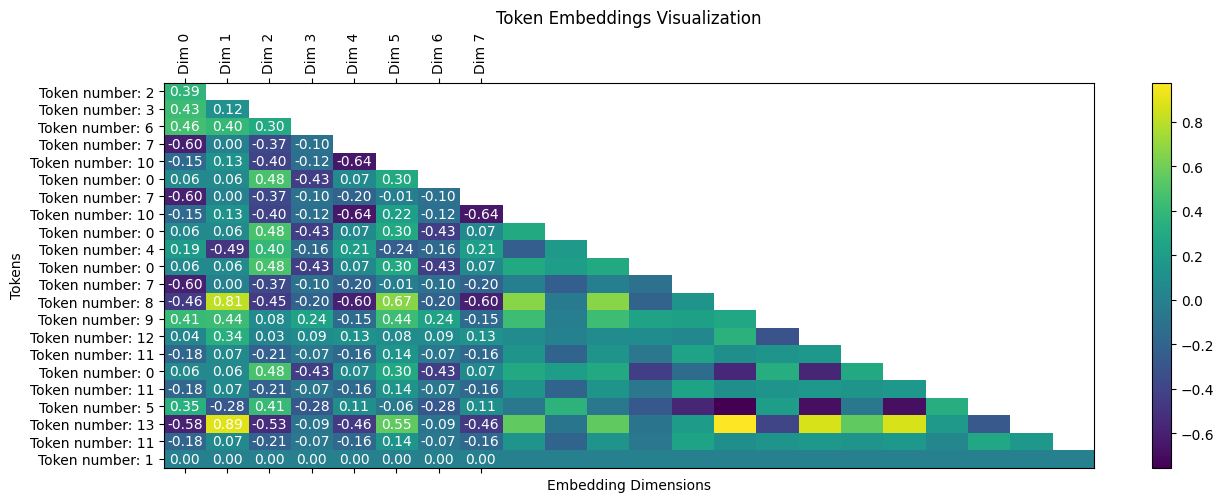

Softmaxed


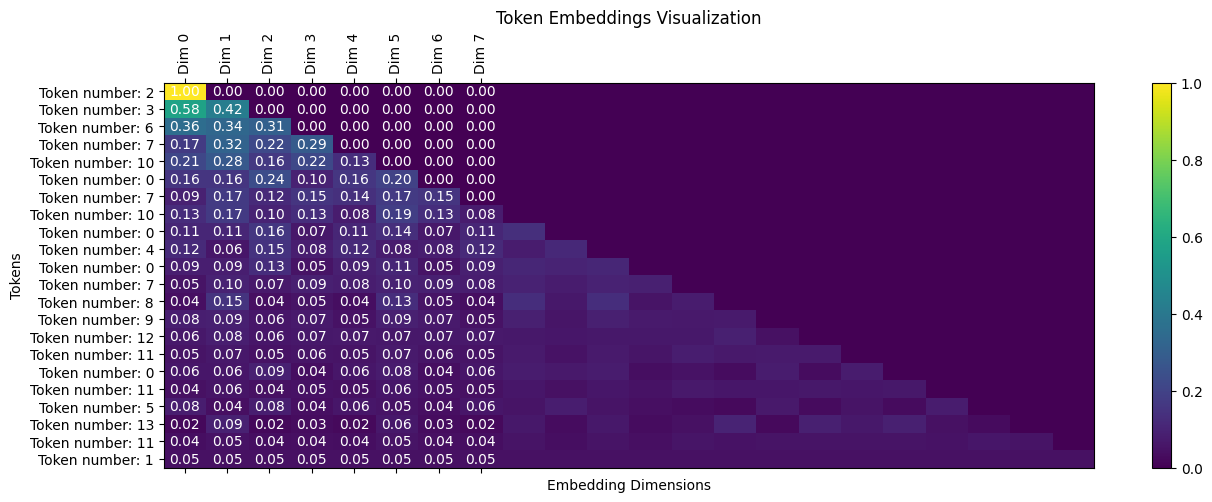

droped out


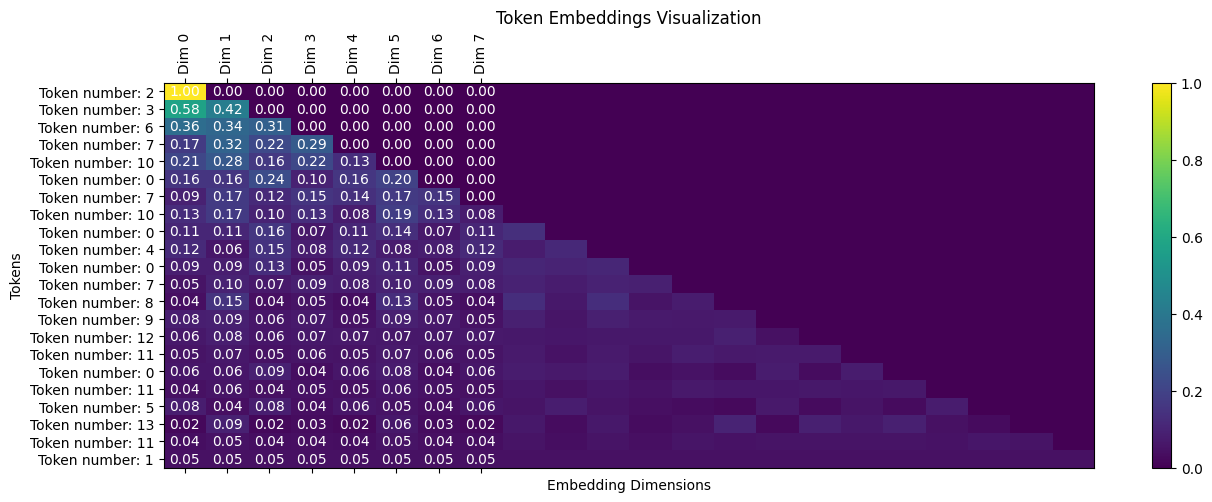

Attentino head output


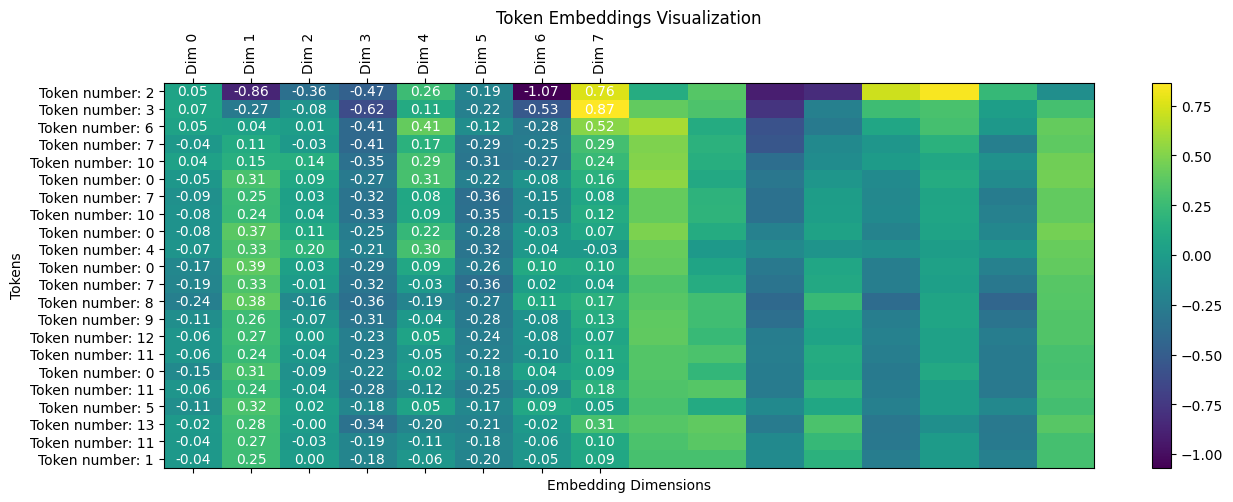

keys beggining


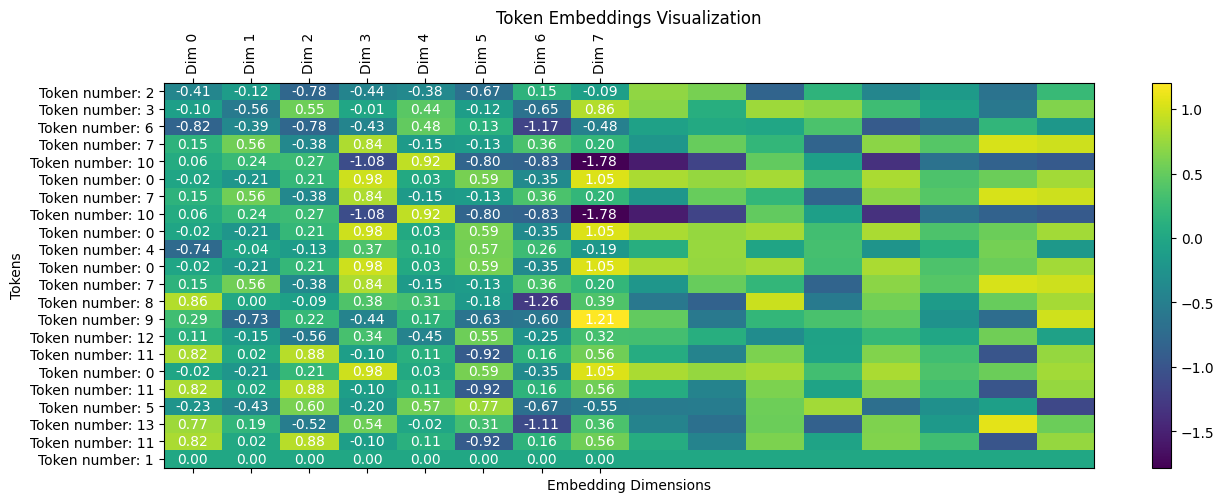

queries beggining


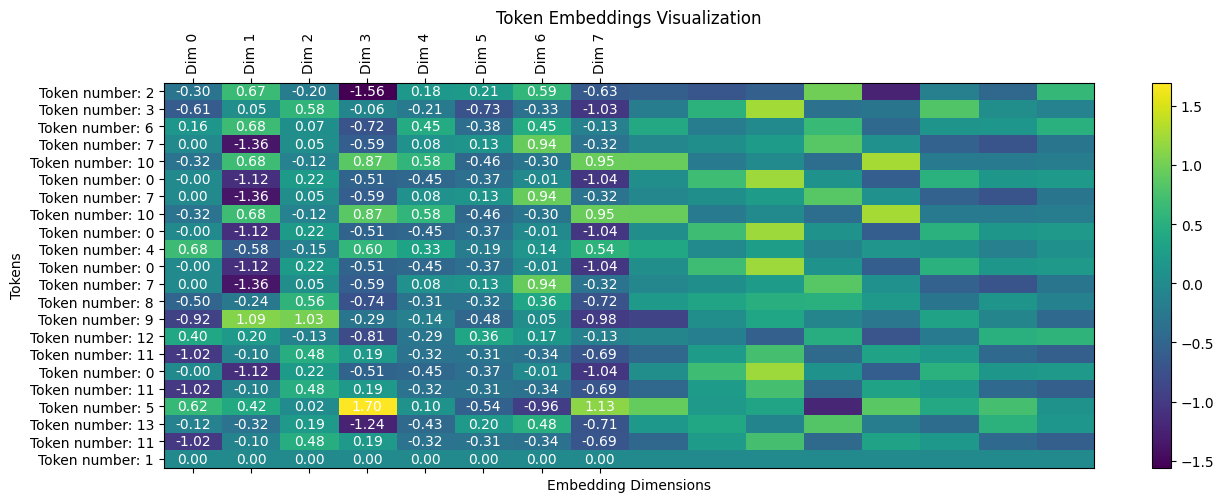

values beggining


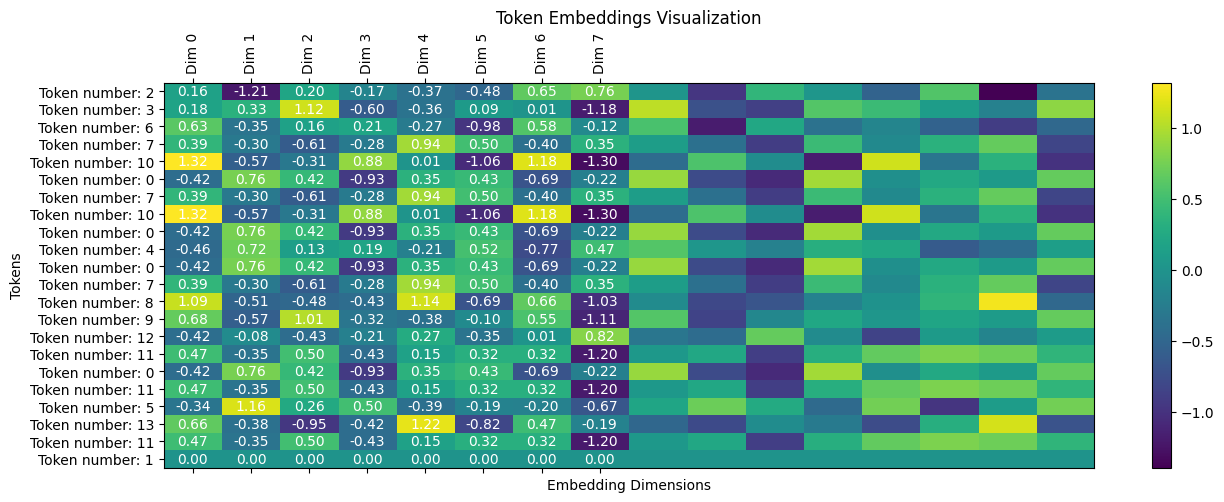

keys and queries multiplied


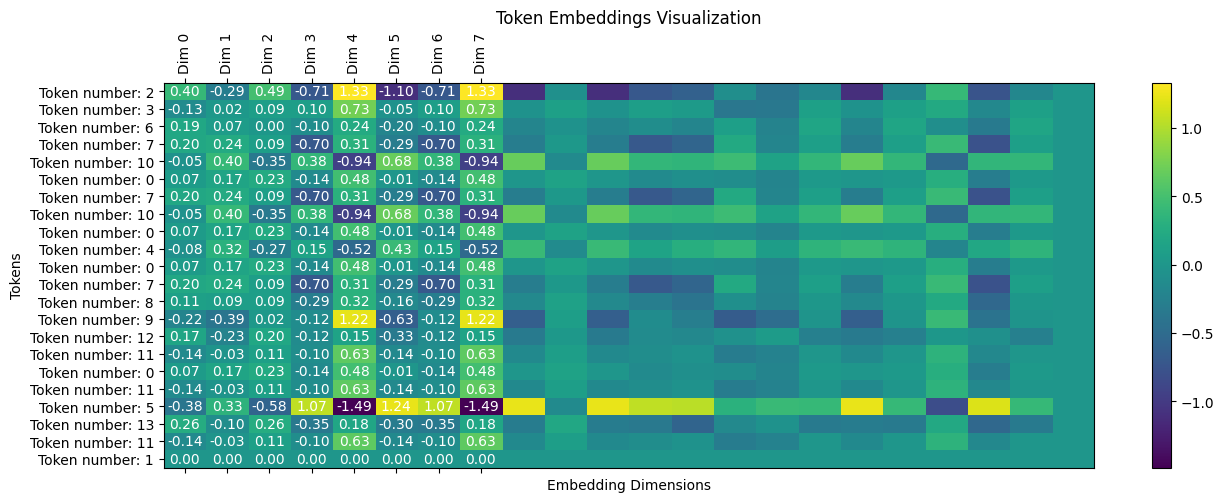

Masked


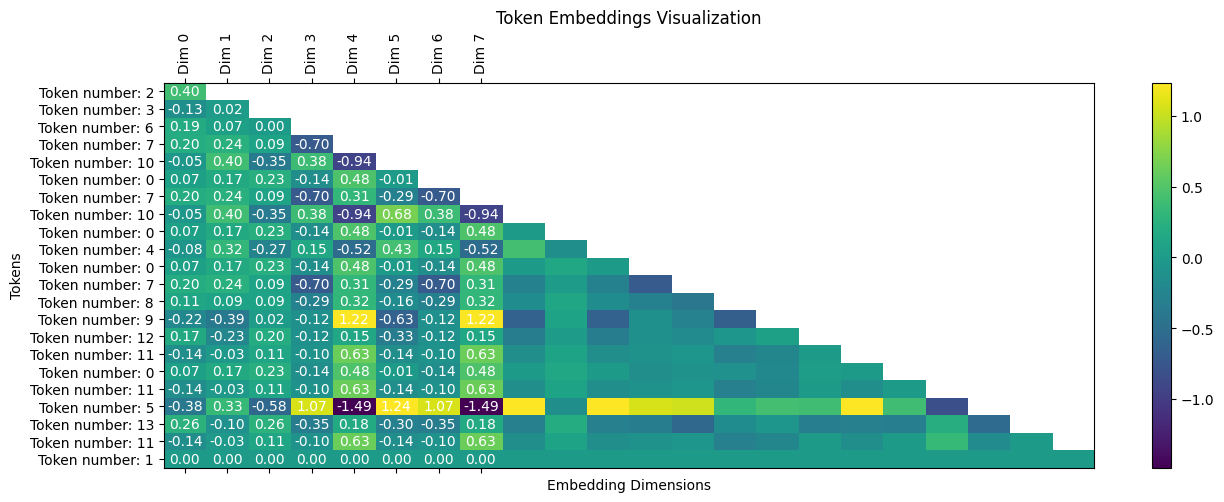

Softmaxed


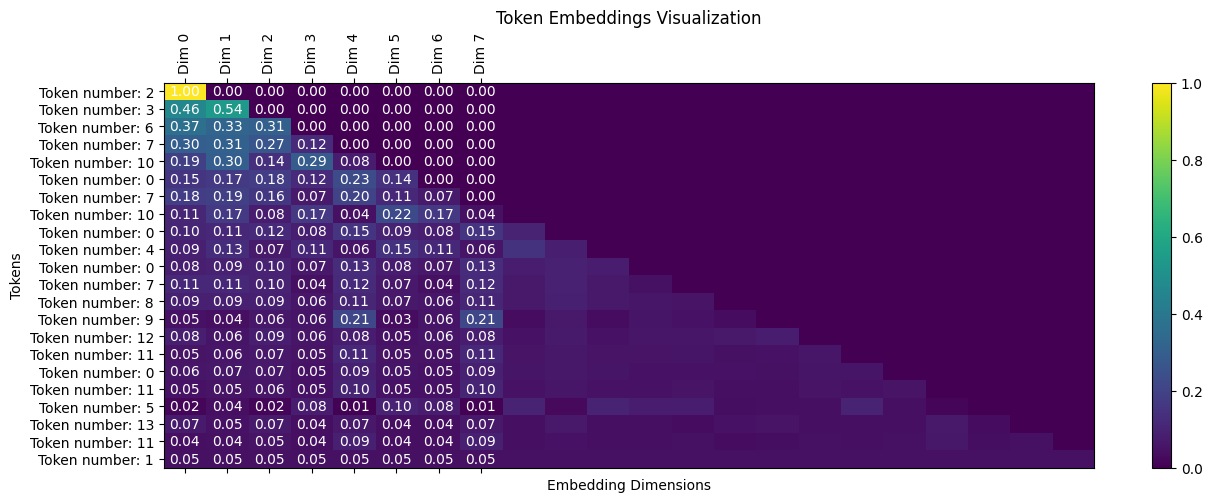

droped out


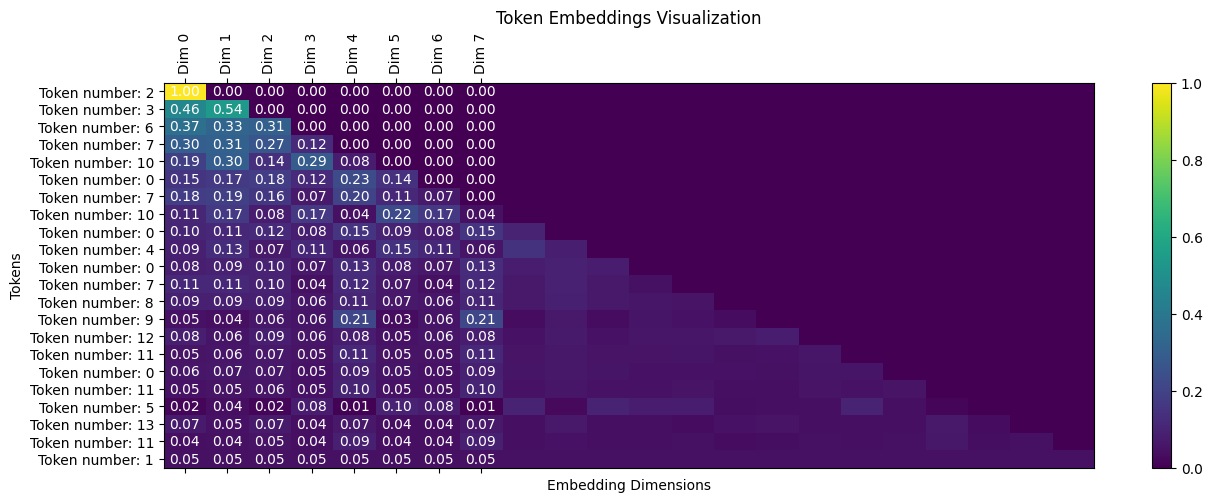

Attentino head output


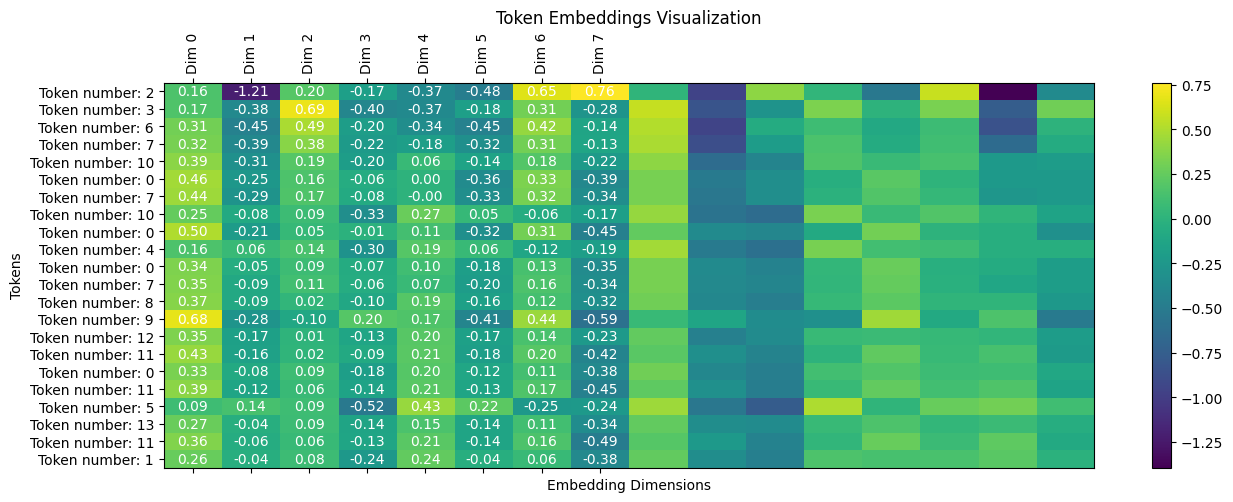

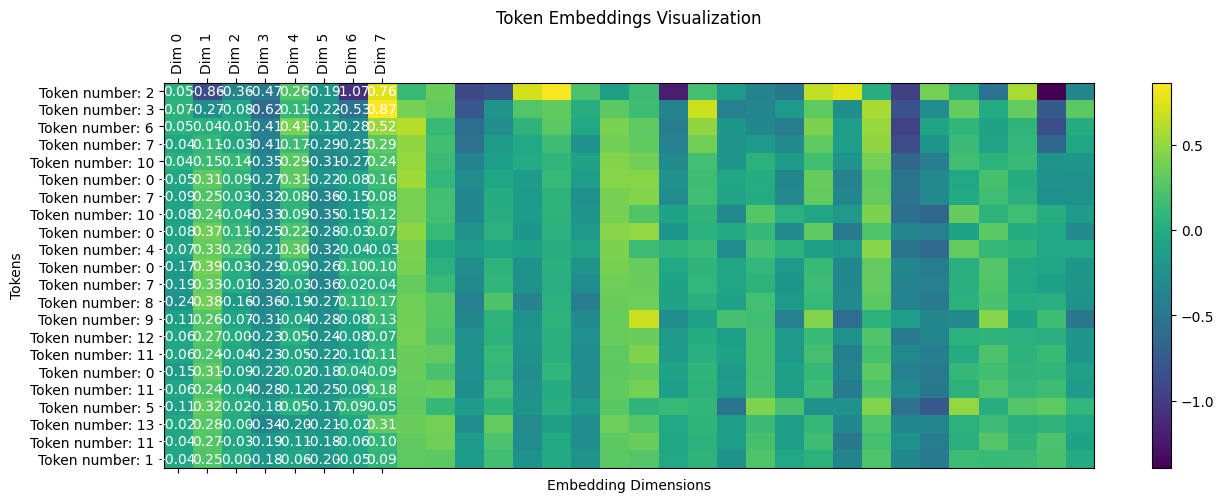

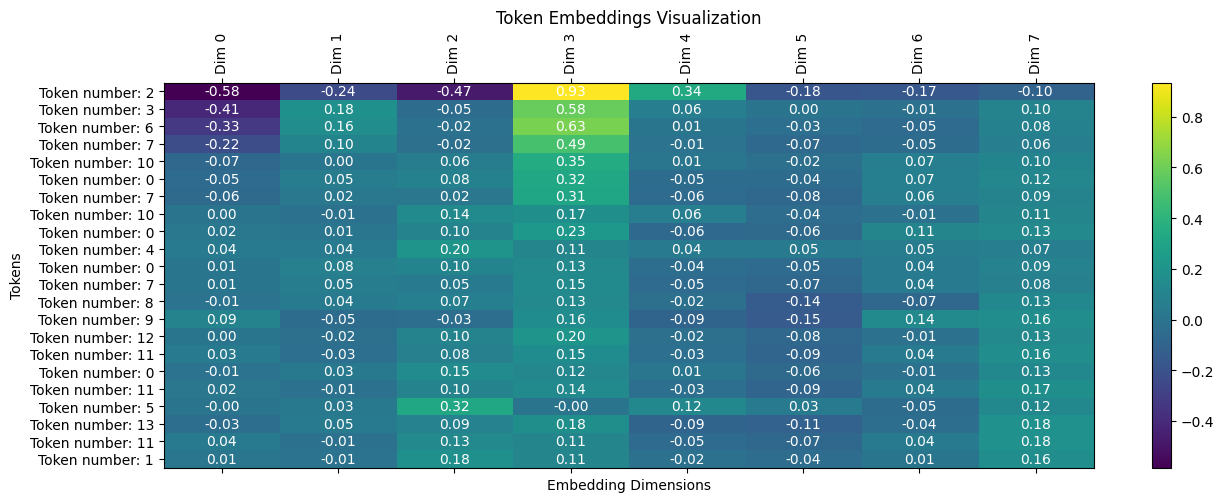

torch.Size([22, 8])
tensor([[-5.8376e-01, -2.3836e-01, -4.7485e-01,  9.3487e-01,  3.3948e-01,
         -1.7823e-01, -1.6612e-01, -9.9782e-02],
        [-4.0638e-01,  1.7738e-01, -4.6992e-02,  5.7949e-01,  6.4915e-02,
          3.1396e-03, -1.0547e-02,  9.6347e-02],
        [-3.3104e-01,  1.6184e-01, -1.6548e-02,  6.2660e-01,  6.7413e-03,
         -2.7541e-02, -5.0233e-02,  8.3303e-02],
        [-2.2336e-01,  9.9625e-02, -2.0799e-02,  4.9382e-01, -5.9195e-03,
         -6.6579e-02, -4.7550e-02,  6.4771e-02],
        [-7.1191e-02,  4.5488e-03,  6.2307e-02,  3.5050e-01,  1.2436e-02,
         -2.4474e-02,  6.6745e-02,  1.0187e-01],
        [-5.3790e-02,  5.4107e-02,  8.3322e-02,  3.2067e-01, -4.6592e-02,
         -4.4542e-02,  7.1524e-02,  1.2160e-01],
        [-5.7687e-02,  2.4566e-02,  1.6844e-02,  3.1097e-01, -5.5108e-02,
         -7.8439e-02,  6.3621e-02,  9.4213e-02],
        [ 1.4404e-03, -1.4712e-02,  1.4233e-01,  1.7456e-01,  6.4494e-02,
         -4.0416e-02, -1.1715e-02,  1.0763e-0

In [78]:
mha_output = mha(embeddings)
print(mha_output.shape)
print(mha_output)

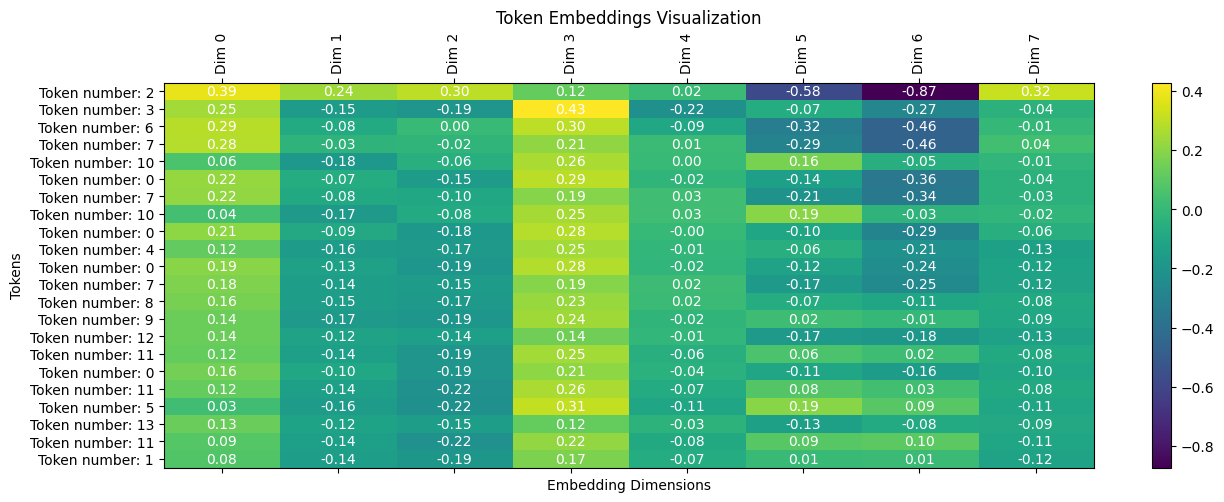

In [67]:
createPlot(mha_output)